<a href="https://colab.research.google.com/github/AntoniaCarrizo/Machine-learning-projects-artificial-intelligence/blob/main/improved_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

What is necessary must be installed to load the data

In [ ]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

The necessary libraries are installed

In [ ]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

The tensorflow database is obtained and the data is separated into train and test (the database is already separated)

In [ ]:
dataset, metadata = tfds.load(name='horses_or_humans', as_supervised=True, with_info=True)

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples, validation_examples = dataset['train'], dataset['test']

#Preprocess data

I normalize the images and leave them a fixed size, this will serve so that the trained model receives the images correctly

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = metadata.splits['train'].num_examples

BATCH_SIZE = 10
IMAGE_RES = 240

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Transfer Learning with TensorFlow Hub

I selected the following trained model because in its information it says that it is for image classification, which is what we are looking for, it also says that it has good precision (this is demonstrated in the results). The size of the input says that it is flexible so it works with different sizes, also to make training and prediction simpler, the images were made 240x240 which is how the model used was trained, it was also normalized since it is specified which must have color values in the range [0,1]. I decided on this model since it gave good results and did not throw errors, other models that I tested threw errors when occupying an output layer of 2.

In [ ]:
URL = "https://tfhub.dev/google/efficientnet/b1/classification/1"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [ ]:
feature_extractor.trainable = False

#Complete model

A new output layer is added to later only train this since the model is previously trained.

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              7856232   
_________________________________________________________________
dense (Dense)                (None, 2)                 2002      
Total params: 7,858,234
Trainable params: 2,002
Non-trainable params: 7,856,232
_________________________________________________________________


# Train the model

I train with the adam optimizer, which is the one we have used the most, and with the SparceCategoricalCrossentropy loss function since we have categories, human or horse.

I only train with 1 epoch because with more he overtrains and the precision goes up to 1.

In [ ]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

103/103 [==============================] - 46s 108ms/step - loss: 0.3339 - accuracy: 0.9815 - val_loss: 0.3154 - val_accuracy: 1.0000


# Check the predictions


In [ ]:
class_names = np.array(metadata.features['label'].names)
class_names

array(['horses', 'humans'], dtype='<U6')

Run an image batch through the model and convert the indices to class names.

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['humans', 'humans', 'horses', 'humans', 'humans', 'horses',
       'horses', 'humans', 'humans', 'humans'], dtype='<U6')

Let's look at the true labels and predicted ones.

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 0 1 1 0 0 1 1 1]
Predicted labels:  [1 1 0 1 1 0 0 1 1 1]


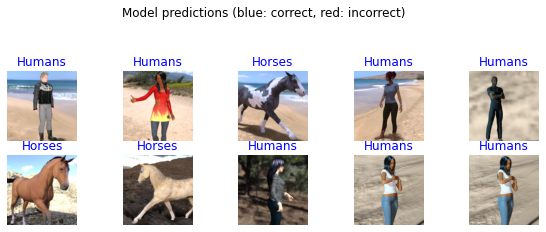

In [ ]:
plt.figure(figsize=(10,9))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Good results are obtained and all predictions are correct.

# Export as SavedModel


In [ ]:
export_path_sm = "./{}".format('project5')
print(export_path_sm)
model.save(export_path_sm)

./project5
INFO:tensorflow:Assets written to: ./project5/assets


INFO:tensorflow:Assets written to: ./project5/assets


In [ ]:
!ls {export_path_sm}

assets	keras_metadata.pb  saved_model.pb  variables


#Loading the SavedModel as a Keras Model


To be able to get back a full keras model from the Tensorflow SavedModel format we must use the tf.keras.models.load_model function.

In [ ]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              7856232   
_________________________________________________________________
dense (Dense)                (None, 2)                 2002      
Total params: 7,858,234
Trainable params: 2,002
Non-trainable params: 7,856,232
_________________________________________________________________


#Check that the reloaded KerasModel and the previous model give the same results

Now, let's use the `reloaded_sm)keras` (reloaded Keras model from our SavedModel) to make predictions on a batch of images.

In [ ]:
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

We can verify that the reloaded Keras model and the previous model give the same result because the difference between them gives us 0.0.

In [ ]:
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

#Download model

In [ ]:
!zip -r model.zip {export_path_sm}

  adding: project5/ (stored 0%)
  adding: project5/saved_model.pb (deflated 92%)
  adding: project5/keras_metadata.pb (deflated 80%)
  adding: project5/variables/ (stored 0%)
  adding: project5/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: project5/variables/variables.index (deflated 80%)
  adding: project5/assets/ (stored 0%)


I see where it is kept:

In [ ]:
!ls

model.zip  project5  sample_data


I download to local disk.

In [ ]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>